# Training Using Deep Learning

### Import Dependencies

In [ ]:
import os
from multiprocessing import Pool
import pickle

import numpy as np
import pandas as pd

import soundfile as sf
import librosa

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

from sklearn.metrics import classification_report
import sklearn

torch.manual_seed(42)

Check if GPU acceleration is available so we train and use the model efficiently.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'Cuda version: {torch.version.cuda}')

# If this doesn't work, you may need to download the correct cuda version from PyTorch

Using device: cuda
Cuda version: 13.0


### Load & Extract Data
This time we will be extracting Mel-Spectrogram from the ASVspoof and Fake-or-Real dataset.
Explain...

In [5]:
from mfcc_extraction import make_spectrogram

cache_path = '../data/.cache/dataloader_cache.pkl'

train_protocol = '../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
train_file_path_ASV = '../data/ASVspoof_Dataset/ASVspoof2019_LA_train/flac/'
train_file_path_FoR = '../data/The Fake-or-Real (FoR) Dataset (deepfake audio)/training/'
train_df = pd.read_csv(train_protocol, delimiter=' ', names=['SPEAKER_ID', 'AUDIO_FILE_NAME', 'SYSTEM_ID', '-', 'KEY'])

# The Fake-or-Real Dataset contains some corrupted files in the training set 
# which have previously been found noted here to avoid
corrupted_files = {'file13424.mp3','file15746.mp3','file16643.mp3','file17407.mp3','file17450.mp3','file19851.mp3','file27206.mp3','file27643.mp3','file27839.mp3','file30959.mp3','file31017.mp3','file32972.mp3','file5323.mp3','file9875.mp3'} 


test_protocol = '../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'
test_file_path_ASV = '../data/ASVspoof_Dataset/ASVspoof2019_LA_eval/flac/'
test_file_path_FoR = '../data/The Fake-or-Real (FoR) Dataset (deepfake audio)/testing/'
test_df = pd.read_csv(test_protocol, delimiter=' ', names=['SPEAKER_ID', 'AUDIO_FILE_NAME', 'SYSTEM_ID', '-', 'KEY'])

batch_size = 32

def multiprocess_spectrograms(paths, n_process, chunksize=128):
    shape = make_spectrogram(paths[0]).shape
    spectrograms = np.empty((len(paths), shape[0], shape[1]), dtype=np.float32)

    with Pool(n_process) as p: 
        for i, spec in enumerate(p.imap(make_spectrogram, paths, chunksize=chunksize)):
            spectrograms[i] = spec
            if i % 1000 == 0:
                print(f'{i}/{len(paths)} spectrograms computed')
        print(f'{len(paths)}/{len(paths)} spectrograms computed') 
    return spectrograms

def file_to_spec_tensor(path):
    return torch.tensor(make_spectrogram(path), dtype=torch.float32).unsqueeze(0)

# Originally used to check a if a file was corrupted
def check_corrupted(path): 
    try:
        sf.read(path, dtype=np.float32)
        return True
    except:
        print('Corrupted:', path)
        return False

# The FoR dataset stores files into a fake and real folder which we need to read from
def read_FoR_array(path):
    fake_paths_training = []
    real_paths_training = []

    for file in os.listdir(path + '/fake'):
        curr_path = path + 'fake/' + file
        if file not in corrupted_files:
            fake_paths_training.append(curr_path)
    for file in os.listdir(path + '/real'):
        curr_path = path + 'real/' + file
        real_paths_training.append(curr_path)
    
    paths = np.array(fake_paths_training + real_paths_training)
    labels = np.array([0] * len(fake_paths_training) + [1] * len(real_paths_training))

    return paths, labels

class log_mel_spect_dataset(Dataset):
    def __init__(self, spectrograms, labels):
        self.spectrograms = torch.tensor(spectrograms, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

ASV_training_paths = train_file_path_ASV + train_df['AUDIO_FILE_NAME'].to_numpy() + '.flac' 
training_labels = np.array(train_df['KEY'].map(lambda x: x == 'bonafide'))

FoR_training_dataset = read_FoR_array(train_file_path_FoR)
FoR_training_paths = FoR_training_dataset[0]
training_labels = np.concatenate([training_labels, FoR_training_dataset[1]])


ASV_test_paths = test_file_path_ASV + test_df['AUDIO_FILE_NAME'].to_numpy() + '.flac' 
test_labels = np.array(test_df['KEY'].map(lambda x: x == 'bonafide'))


FoR_testing_dataset = read_FoR_array(test_file_path_FoR)
FoR_test_paths = FoR_testing_dataset[0]
test_labels = np.concatenate([test_labels, FoR_testing_dataset[1]])

### Compute Spectrograms
Using the librosa library, we will resample all files to 16kbs, and generate a 3 second mel sepectrogram.
Then, the spectrogram is normalized and converted to a logmaritic scale.

In [6]:
if os.path.exists(cache_path):
    print('Loading Cached data')
    with open(cache_path, 'rb') as file:
        cache_data = pickle.load(file)
    training_spectrograms = cache_data['training_spectrograms']
    training_dataset = cache_data['training_dataset']
    training_loader = cache_data['training_loader']

    test_spectrograms = cache_data['test_spectrograms']
    test_dataset = cache_data['test_dataset']
    test_loader = cache_data['test_loader']
    print('Loaded Cached data')
else:

    print('Computing Training Data:')

    training_spectrograms = np.concat([multiprocess_spectrograms(ASV_training_paths, os.cpu_count()),
                                    multiprocess_spectrograms(FoR_training_paths, os.cpu_count())])
    training_dataset = log_mel_spect_dataset(training_spectrograms, training_labels)
    training_loader = DataLoader(training_dataset,
                                batch_size=batch_size,
                                num_workers=0,
                                pin_memory=True,
                                shuffle=True)

    print('Computing Test Data:')
    test_spectrograms = np.concat([multiprocess_spectrograms(ASV_test_paths, os.cpu_count()),
                                multiprocess_spectrograms(FoR_test_paths, os.cpu_count())])
    test_dataset = log_mel_spect_dataset(test_spectrograms, test_labels)
    test_loader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                num_workers=0,
                                pin_memory=True)

    cache_data = {
        'training_spectrograms': training_spectrograms,
        'training_dataset': training_dataset,
        'training_loader': training_loader,

        'test_spectrograms': test_spectrograms,
        'test_dataset': test_dataset,
        'test_loader': test_loader
    }

    with open(cache_path, 'wb') as file:
        pickle.dump(cache_data, file)

    print('Finished processing and caching data')

Loading Cached data
Loaded Cached data


### Build the Model
We will being making Convolutional Neural Network that takes in a image as input, feeds through a series of convolution layers, activation functions, pooling layers before being connected to fully connected layers. This eventually lead to the output of a single tensor as a logit or raw value. This needs to be put into a sigmoid function to calculate the probability between (0, 1) and then needs to be put through a classification threshold to get the actual output.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=43648, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

### Training the Model
Here we will train the model for the specified number of epochs and then calculate the train and test loss to be plotted.

Beginning Training:
Epoch: 1, loss: 415.8163107065484
Epoch: 2, loss: 149.14199259644374
Epoch: 3, loss: 90.24985833937535
Epoch: 4, loss: 60.150307518139016
Epoch: 5, loss: 46.3439955933718
Epoch: 6, loss: 37.29183319075673
Epoch: 7, loss: 32.91947758119204
Epoch: 8, loss: 29.824698998621898
Epoch: 9, loss: 26.7814128062455
Epoch: 10, loss: 24.146963057020912
Epoch: 11, loss: 23.38268745219102
Epoch: 12, loss: 22.18554214478354
Finished Training


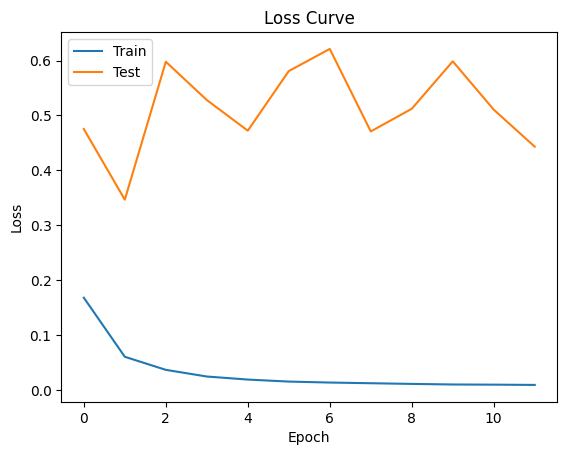

In [ ]:
n_epoch = 12

net = Net()
net.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), 
                    lr=0.001,
                    weight_decay=0.01,
                    momentum=0.1)

train_loss_data = []
test_loss_data =[]

def train_model():
    net.train()
    print('Beginning Training:')
    for epoch in range(n_epoch):
        training_running_loss = 0.0
        test_running_loss = 0.0

        for i, data in enumerate(training_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()

            outputs = torch.sigmoid(net(inputs))
            loss = criterion(outputs, labels) # calculate train loss
            loss.backward()
            optimizer.step()

            training_running_loss += loss.item()
        train_loss_data.append(training_running_loss / len(training_loader))
        
        # Calculate test loss
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = torch.sigmoid(net(inputs))
                test_running_loss += criterion(outputs, labels).item()
            
            test_loss_data.append(test_running_loss / len(test_loader))   
        
        
        print(f'Epoch: {epoch+1}, loss: {training_running_loss}')
    print('Finished Training')

train_model()

plt.plot(train_loss_data, label='Train')
plt.plot(test_loss_data, label='Test')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Save the model

In [7]:
PATH = '../models/nn_model.pth'

In [203]:
torch.save(net.state_dict(), PATH)

### Load the Model

In [8]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
net.to(device)
net.eval()

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=43648, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=1, bias=True)
)

### Evaluating Model Statistics

In [9]:
threshold = 0.5

def predict(path):
    outputs = net(file_to_spec_tensor(path).to(device).unsqueeze(0))
    return (outputs >= threshold).item()

In [ ]:
# You can test certain examples or your files using this function
# print(predict('../data/The Fake-or-Real (FoR) Dataset (deepfake audio)/training/file36.mp3'))

Calculate the accuracy score from the test set and find the FP, FN, TP, and TN.

In [10]:
correct = 0
total = 0
predictions = []
false_positives = []
false_negatives = []
true_positives = []
true_negatives = []

with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = torch.sigmoid(net(inputs))
        predicted = (outputs >= threshold)

        total += labels.size(0)
        check = predicted == labels
        for j in range(len(check)):
            if predicted[j] != labels[j]:
                if predicted[j] == 0:
                    false_negatives.append(test_spectrograms[i + j])
                else:
                    false_positives.append(test_spectrograms[i + j])
            else:
                if predicted[j] == 0:
                    true_negatives.append(test_spectrograms[i + j])
                else:
                    true_positives.append(test_spectrograms[i + j])

        correct += check.sum().item()

        predictions.extend(predicted.cpu().detach().numpy())

print(f'Accuracy: {100 * correct / total} %')


Accuracy: 89.29235149134716 %


### Classification Report
From this table we can see that the precision for real files has significantly improved compared to the logistic regression model.

In [11]:
test_predictions = np.array(predictions)
report = pd.DataFrame(sklearn.metrics.classification_report(test_labels, test_predictions, target_names=['fake', 'real'], output_dict=True)).T
report['support'] = report.support.apply(int)
round_col = report.columns.difference(['support'])
report[round_col] = report[round_col].map(lambda x: f'{round(x*100, 2)}%')
report.style

,precision,recall,f1-score,support
fake,97.35%,90.19%,93.63%,66252
real,55.16%,83.09%,66.3%,9619
accuracy,89.29%,89.29%,89.29%,0
macro avg,76.25%,86.64%,79.97%,75871
weighted avg,92.0%,89.29%,90.17%,75871


### Visualize model network
Here we are using TorchViz to alternatively generate a map of the neural network.

In [195]:
# Generates an image of the neural network

# from torchviz import make_dot

# data = next(iter(training_loader))
# # print(data.shape) # torch.Size([32, 1, 128, 94])

# make_dot(torch.sigmoid(net(data[0].to(device))), params=dict(list(net.named_parameters()))).render('rnn_torchviz', format='svg')


![Model Visualization](../images/rnn_torchviz.svg)

### Generating a Confusion Matrix
Here we can see that we seem has classified significantly less fake files as real.

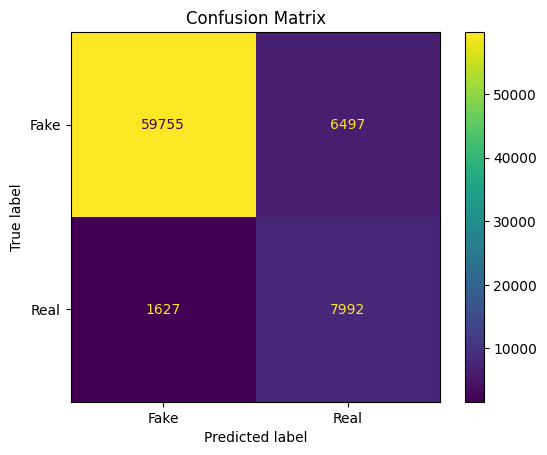

In [34]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predictions, display_labels=['Fake', 'Real'], values_format='')

plt.title('Confusion Matrix')
plt.show()

### Visualizing False Positives/False Negatives



In [1]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

def plot_mfcc(spect, row, col, title='Mel-frequency spectrogram', colorbar=False):
    
    img = librosa.display.specshow(spect, x_axis='time', y_axis='mel', sr=16000, fmax=8000, ax=ax[row][col])
    if colorbar:
        fig.colorbar(img, ax=ax[row][col], format='%+2.0f dB')
    ax[row][col].set(title=title)

plot_mfcc(true_negatives[1], 0, 0, 'Mel-Frequency Spectrogram (True Negative)', False)
plot_mfcc(false_positives[1], 0, 1, 'Mel-Frequency Spectrogram (False Positive)', True)
plot_mfcc(false_negatives[1], 1, 0, 'Mel-Frequency Spectrogram (False Negative)', False)
plot_mfcc(true_positives[2], 1, 1, 'Mel-Frequency Spectrogram (True Positive)', True)

NameError: name 'plt' is not defined